In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import dlisio
import pandas as pd
import numpy as np
import scipy.signal as signal
import logging
import copy

# Ensure that we can see pandas tables of up to 500 rows
pd.set_option('display.max_rows', 500)

# Set a default DPI for all figures in this file. Lower DPI gives smaller figures, higher bigger.
mpl.rcParams['figure.dpi'] = 100

In [2]:
dlisio.set_encodings(['latin1'])

In [3]:
filename = '1194B_MESTB _017_1B.dlis'

f, *f_tail = dlisio.load(filename)

if len(f_tail): logging.warning('There are more logical files in tail')

In [4]:
origin, *origin_tail = f.origins

if len(origin_tail): logging.warning('f contains multiple origins')

In [5]:
f.describe()

------------
Logical File
------------
Description : dlis(MESTB .017)
Frames      : 1
Channels    : 89

Known objects
--
FILE-HEADER : 1
CHANNEL     : 89
TOOL        : 2
ORIGIN      : 2
FRAME       : 1
PARAMETER   : 491


In [6]:
origin, *origin_tail = f.origins
print(len(origin_tail))

1


In [7]:
origin.describe()

------
Origin
------
name   : WELL-ODP Leg 194, Site 1194B
origin : 27
copy   : 0

Logical file ID          : MESTB .017
File set name and number : MESTB / 1
File number and type     : 0 / CUSTOMER

Well (id/name)          :  / ODP Leg 194, Site 1194B
Produced by (code/name) : 440 / Schlumberger
Produced for            : Lamont Doherty
Created                 : 2021-09-14 12:08:11

Created by              : Techlog, (version: 2017.2 (rev: 234070))
Other programs/services : WELL-ODP Leg 194, Site 1194B


In [8]:
def summarize(objs, **kwargs):
    """Create a pd.DataFrame that summarize the content of 'objs', One 
    object pr. row
    
    Parameters
    ----------
    
    objs : list()
        list of metadata objects
        
    **kwargs
        Keyword arguments 
        Use kwargs to tell summarize() which fields (attributes) of the 
        objects you want to include in the DataFrame. The parameter name 
        must match an attribute on the object in 'objs', while the value 
        of the parameters is used as a column name. Any kwargs are excepted, 
        but if the object does not have the requested attribute, 'KeyError' 
        is used as the value.
        
    Returns
    -------
    
    summary : pd.DataFrame
    """
    summary = []
    for attr, label in kwargs.items():
        column = []
        for obj in objs:
            try:
                value = getattr(obj, attr)
            except AttributeError:
                value = 'KeyError'
    
            column.append(value)
        summary.append(column)

    summary = pd.DataFrame(summary).T
    summary.columns = kwargs.values()
    return summary

In [9]:
for frame in f.frames:
    
    # Search through the channels for the index and obtain the units
    for channel in frame.channels:
        if channel.name == frame.index:
            depth_units = channel.units
    
    print(f'Frame Name: \t\t {frame.name}')
    print(f'Index Type: \t\t {frame.index_type}')
    print(f'Depth Interval: \t {frame.index_min} - {frame.index_max} {depth_units}')
    print(f'Depth Spacing: \t\t {frame.spacing} {depth_units}')
    print(f'Direction: \t\t {frame.direction}')
    print(f'Num of Channels: \t {len(frame.channels)}')
    print(f'Channel Names: \t\t {str(frame.channels)}')
    print('\n\n')

Frame Name: 		 1B
Index Type: 		 BOREHOLE-DEPTH
Depth Interval: 	 179280.99999999997 - 319200.0 0.1 in
Depth Spacing: 		 -1.0000000000000002 0.1 in
Direction: 		 DECREASING
Num of Channels: 	 89
Channel Names: 		 [Channel(TDEP), Channel(ASSOC_CAL), Channel(AX), Channel(AY), Channel(AZ), Channel(BA11), Channel(BA12), Channel(BA13), Channel(BA14), Channel(BA15), Channel(BA16), Channel(BA17), Channel(BA18), Channel(BA21), Channel(BA22), Channel(BA23), Channel(BA24), Channel(BA25), Channel(BA26), Channel(BA27), Channel(BA28), Channel(BB11), Channel(BB12), Channel(BB13), Channel(BB14), Channel(BB15), Channel(BB16), Channel(BB17), Channel(BB18), Channel(BB21), Channel(BB22), Channel(BB23), Channel(BB24), Channel(BB25), Channel(BB26), Channel(BB27), Channel(BB28), Channel(BC11), Channel(BC12), Channel(BC13), Channel(BC14), Channel(BC15), Channel(BC16), Channel(BC17), Channel(BC18), Channel(BC21), Channel(BC22), Channel(BC23), Channel(BC24), Channel(BC25), Channel(BC26), Channel(BC27), Channel

In [10]:
def summary_dataframe(object, **kwargs):
    # Create an empty dataframe
    df = pd.DataFrame()
    
    # Iterate over each of the keyword arguments
    for i, (key, value) in enumerate(kwargs.items()):
        list_of_values = []
        
        # Iterate over each parameter and get the relevant key
        for item in object:
            # Account for any missing values.
            try:
                x = getattr(item, key)
                list_of_values.append(x)
            except:
                list_of_values.append('')
                continue
        
        # Add a new column to our data frame
        df[value]=list_of_values
    
    # Sort the dataframe by column 1 and return it
    return df.sort_values(df.columns[0])


In [11]:
param_df = summary_dataframe(f.parameters, name='Name', long_name='Long Name', values='Value')

# Hiding people's names that may be in parameters.
# These two lines can be commented out to show them
mask = param_df['Name'].isin(['R8', 'RR1', 'WITN', 'ENGI'])
param_df = param_df[~mask]

param_df

,Name,Long Name,Value
468,ACCC,Accelerometer coefficients,[-0.0004;0;0.0011;-0.0003;2e-06;-7.6e-05;1e-06...
467,ACCM,Accelerometer Month of Calibration,[10]
457,ACCN,Accelerometer Serial Number,[448]
471,ACCT,Accelerometer Type (Manufacturer Code),[3]
459,ACCY,Accelerometer Year of Calibration,[92]
461,ACPP,Accelerometer PROM Presence,[PRESENT]
403,ACQUISITION-PRODUCT,,[OP]
466,AFMO,Accelerometer Filtering Mode,[MAVE]
31,ALTDPCHAN,Name of alternate depth channel,[SPEEDCORRECTEDDEPTH]
324,ALTDPCHAN,Name of alternate depth channel,[SPEEDCORRECTEDDEPTH]


In [12]:
channels = summary_dataframe(f.channels, name='Name', long_name='Long Name', dimension='Dimension', units='Units', frame='Frame')
channels

,Name,Long Name,Dimension,Units,Frame
1,ASSOC_CAL,,[1],in,Frame(1B)
2,AX,X Acceleration,[1],m/s2,Frame(1B)
3,AY,Y Acceleration,[1],m/s2,Frame(1B)
4,AZ,Z Acceleration,[1],m/s2,Frame(1B)
5,BA11,CALIBRATED DATA BUTTON A11,[1],,Frame(1B)
6,BA12,CALIBRATED DATA BUTTON A12,[1],,Frame(1B)
7,BA13,CALIBRATED DATA BUTTON A13,[1],,Frame(1B)
8,BA14,CALIBRATED DATA BUTTON A14,[1],,Frame(1B)
9,BA15,CALIBRATED DATA BUTTON A15,[1],,Frame(1B)
10,BA16,CALIBRATED DATA BUTTON A16,[1],,Frame(1B)


In [13]:
tools = summary_dataframe(f.tools, name='Name', description='Description')
tools

,Name,Description
0,MESTB,Micro Electrical Scanner - B (Slim)
1,NGTC,Natural Gamma Spectroscopy - C


In [14]:
mestb = f.object('TOOL', 'MESTB')
mestb_params = summary_dataframe(mestb.parameters, name='Name', long_name='Long Name', values='Values')
mestb_params

,Name,Long Name,Values
27,ACCC,Accelerometer coefficients,[-0.0004;0;0.0011;-0.0003;2e-06;-7.6e-05;1e-06...
26,ACCM,Accelerometer Month of Calibration,[10]
16,ACCN,Accelerometer Serial Number,[448]
30,ACCT,Accelerometer Type (Manufacturer Code),[3]
18,ACCY,Accelerometer Year of Calibration,[92]
20,ACPP,Accelerometer PROM Presence,[PRESENT]
25,AFMO,Accelerometer Filtering Mode,[MAVE]
10,ART,Accelerometer Reference Temperature,[20.0]
32,ATIM,Time of acc calibration,[980464209]
7,GLM,GPIT Logging Mode,[DIPM]


In [15]:
mestb.describe()

----
Tool
----
name   : MESTB
origin : 28
copy   : 0

Description    : Micro Electrical Scanner - B (Slim)
Trademark name : MEST-B
Generic name   : MES

Channels   : BD23      BD15      BC26      BC17      BC16      P1AZ      BC11
             BB13      BB15      FY        BD22      BA11      BA24      BD13
             BD18      BA27      FINC      BC14      BB26      BD27      BB11
             AY        BA22      BD21      BC13      BA28      BA21      BA17
             BB12      BB21      EV        BC15      P1AZ_GPIT BB24      BA15
             BA12      BC28      BD26      BA26      BB22      C2        HAZI
             BA18      BB23      BB25      BB14      DEVIM     FCAY      HAZIM
             BA23      P1AZ_MEST BD25      AX        BB17      DEVI      BB27
             BD28      BC27      AZ        BB18      BB28      BD12      BC25
             BC24      C1        BD24      BC18      BA25      RB        BA13
             FCAX      FCAZ      BD11      BD14      BC23      BC2

In [16]:
frame1 =f.object('FRAME','1B') 

In [17]:
curves = frame1.curves()

In [18]:
df = pd.DataFrame(frame.curves())
df

,FRAMENO,TDEP,ASSOC_CAL,AX,AY,AZ,BA11,BA12,BA13,BA14,...,FTIM,FX,FY,FZ,HAZI,HAZIM,P1AZ,P1AZ_GPIT,P1AZ_MEST,RB
0,1,319200.0,2.769085,-0.039766,-0.000230,9.866732,2.392578,2.373047,2.402344,2.143555,...,0.008131,18.902456,-17.195450,-27.957338,256.522522,256.522522,54.772896,54.772896,54.772896,158.248917
1,2,319199.0,2.769085,-0.039328,-0.000159,9.867810,2.392578,2.373047,2.402344,2.143555,...,0.008538,18.902216,-17.196480,-27.959108,256.525085,256.522522,54.772900,54.772896,54.772896,158.246460
2,3,319198.0,2.769085,-0.038890,-0.000088,9.868889,2.392578,2.373047,2.402344,2.143555,...,0.033331,18.901974,-17.197508,-27.960878,256.527618,256.522522,54.772903,54.772896,54.772896,158.244003
3,4,319197.0,2.769085,-0.038452,-0.000017,9.869968,2.392578,2.373047,2.402344,2.143555,...,0.033331,18.901733,-17.198538,-27.962648,256.530151,256.522522,54.772903,54.772896,54.772896,158.241547
4,5,319196.0,2.769085,-0.038014,0.000054,9.871047,2.392578,2.373047,2.402344,2.143555,...,0.024806,18.901493,-17.199566,-27.964418,256.532684,256.522522,54.772907,54.772896,54.772896,158.239090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139915,139916,179285.0,2.755763,-9999.000000,-9999.000000,-9999.000000,14.885254,11.721191,10.212402,9.421387,...,0.033344,-9999.000000,-9999.000000,-9999.000000,116.825180,224.186966,118.943398,253.632980,246.080780,2.127352
139916,139917,179284.0,2.755763,-9999.000000,-9999.000000,-9999.000000,14.885254,11.721191,10.212402,9.421387,...,0.033375,-9999.000000,-9999.000000,-9999.000000,116.825180,224.186966,118.943398,253.632980,246.080780,2.127352
139917,139918,179283.0,2.755763,-9999.000000,-9999.000000,-9999.000000,14.885254,11.721191,10.212402,9.421387,...,0.033356,-9999.000000,-9999.000000,-9999.000000,116.825180,224.186966,118.943398,253.632980,246.080780,2.127352
139918,139919,179282.0,2.755763,-9999.000000,-9999.000000,-9999.000000,14.885254,11.721191,10.212402,9.421387,...,0.033319,-9999.000000,-9999.000000,-9999.000000,116.825180,224.186966,118.943398,253.632980,246.080765,2.127352


In [19]:
df["TDEP"]=(df["TDEP"])* 0.00254

In [20]:
df.index = df['TDEP']
df

,FRAMENO,TDEP,ASSOC_CAL,AX,AY,AZ,BA11,BA12,BA13,BA14,...,FTIM,FX,FY,FZ,HAZI,HAZIM,P1AZ,P1AZ_GPIT,P1AZ_MEST,RB
TDEP,,,,,,,,,,,,,,,,,,,,,
810.76800,1,810.76800,2.769085,-0.039766,-0.000230,9.866732,2.392578,2.373047,2.402344,2.143555,...,0.008131,18.902456,-17.195450,-27.957338,256.522522,256.522522,54.772896,54.772896,54.772896,158.248917
810.76546,2,810.76546,2.769085,-0.039328,-0.000159,9.867810,2.392578,2.373047,2.402344,2.143555,...,0.008538,18.902216,-17.196480,-27.959108,256.525085,256.522522,54.772900,54.772896,54.772896,158.246460
810.76292,3,810.76292,2.769085,-0.038890,-0.000088,9.868889,2.392578,2.373047,2.402344,2.143555,...,0.033331,18.901974,-17.197508,-27.960878,256.527618,256.522522,54.772903,54.772896,54.772896,158.244003
810.76038,4,810.76038,2.769085,-0.038452,-0.000017,9.869968,2.392578,2.373047,2.402344,2.143555,...,0.033331,18.901733,-17.198538,-27.962648,256.530151,256.522522,54.772903,54.772896,54.772896,158.241547
810.75784,5,810.75784,2.769085,-0.038014,0.000054,9.871047,2.392578,2.373047,2.402344,2.143555,...,0.024806,18.901493,-17.199566,-27.964418,256.532684,256.522522,54.772907,54.772896,54.772896,158.239090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455.38390,139916,455.38390,2.755763,-9999.000000,-9999.000000,-9999.000000,14.885254,11.721191,10.212402,9.421387,...,0.033344,-9999.000000,-9999.000000,-9999.000000,116.825180,224.186966,118.943398,253.632980,246.080780,2.127352
455.38136,139917,455.38136,2.755763,-9999.000000,-9999.000000,-9999.000000,14.885254,11.721191,10.212402,9.421387,...,0.033375,-9999.000000,-9999.000000,-9999.000000,116.825180,224.186966,118.943398,253.632980,246.080780,2.127352
455.37882,139918,455.37882,2.755763,-9999.000000,-9999.000000,-9999.000000,14.885254,11.721191,10.212402,9.421387,...,0.033356,-9999.000000,-9999.000000,-9999.000000,116.825180,224.186966,118.943398,253.632980,246.080780,2.127352


In [21]:
df.columns

Index(['FRAMENO', 'TDEP', 'ASSOC_CAL', 'AX', 'AY', 'AZ', 'BA11', 'BA12',
       'BA13', 'BA14', 'BA15', 'BA16', 'BA17', 'BA18', 'BA21', 'BA22', 'BA23',
       'BA24', 'BA25', 'BA26', 'BA27', 'BA28', 'BB11', 'BB12', 'BB13', 'BB14',
       'BB15', 'BB16', 'BB17', 'BB18', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25',
       'BB26', 'BB27', 'BB28', 'BC11', 'BC12', 'BC13', 'BC14', 'BC15', 'BC16',
       'BC17', 'BC18', 'BC21', 'BC22', 'BC23', 'BC24', 'BC25', 'BC26', 'BC27',
       'BC28', 'BD11', 'BD12', 'BD13', 'BD14', 'BD15', 'BD16', 'BD17', 'BD18',
       'BD21', 'BD22', 'BD23', 'BD24', 'BD25', 'BD26', 'BD27', 'BD28', 'C1',
       'C2', 'CGR', 'DEVI', 'DEVIM', 'EV', 'FCAX', 'FCAY', 'FCAZ', 'FINC',
       'FTIM', 'FX', 'FY', 'FZ', 'HAZI', 'HAZIM', 'P1AZ', 'P1AZ_GPIT',
       'P1AZ_MEST', 'RB'],
      dtype='object')

In [22]:
fmsdf = df[['BA11', 'BA12', 'BA13', 'BA14', 'BA15', 
               'BA16', 'BA17', 'BA18', 'BA21','BA22', 
               'BA23', 'BA24', 'BA25', 'BA26', 'BA27', 
               'BA28', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17',
               'BB18', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28',
               'BC11', 'BC12', 'BC13', 'BC14', 'BC15', 'BC16', 'BC17', 'BC18', 'BC21',
               'BC22', 'BC23', 'BC24', 'BC25', 'BC26', 'BC27', 'BC28', 'BD11', 'BD12',
               'BD13', 'BD14', 'BD15', 'BD16', 'BD17', 'BD18', 'BD21', 'BD22', 'BD23',
               'BD24', 'BD25', 'BD26', 'BD27', 'BD28']]

In [23]:
fms1df = df[['BA11', 'BA12', 'BA13', 'BA14', 'BA15', 'BA16', 'BA17', 'BA18', 
             'BA21','BA22', 'BA23', 'BA24', 'BA25', 'BA26', 'BA27', 'BA28']]
fms1df

,BA11,BA12,BA13,BA14,BA15,BA16,BA17,BA18,BA21,BA22,BA23,BA24,BA25,BA26,BA27,BA28
TDEP,,,,,,,,,,,,,,,,
810.76800,2.392578,2.373047,2.402344,2.143555,2.241211,2.407227,2.495117,2.490234,2.338867,2.573242,2.392578,2.324219,2.314453,2.524414,2.407227,2.744141
810.76546,2.392578,2.373047,2.402344,2.143555,2.241211,2.407227,2.495117,2.490234,2.338867,2.573242,2.392578,2.324219,2.314453,2.524414,2.407227,2.744141
810.76292,2.392578,2.373047,2.402344,2.143555,2.241211,2.407227,2.495117,2.490234,2.338867,2.573242,2.392578,2.324219,2.314453,2.524414,2.407227,2.744141
810.76038,2.392578,2.373047,2.402344,2.143555,2.241211,2.407227,2.495117,2.490234,2.338867,2.573242,2.392578,2.324219,2.314453,2.524414,2.407227,2.744141
810.75784,2.392578,2.373047,2.402344,2.143555,2.241211,2.407227,2.495117,2.490234,2.338867,2.573242,2.392578,2.324219,2.314453,2.524414,2.407227,2.744141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455.38390,14.885254,11.721191,10.212402,9.421387,9.226074,10.490723,12.458496,16.643066,12.111816,10.993652,9.777832,9.255371,9.841309,11.047363,13.283691,19.645996
455.38136,14.885254,11.721191,10.212402,9.421387,9.226074,10.490723,12.458496,16.643066,12.111816,10.993652,9.777832,9.255371,9.841309,11.047363,13.283691,19.645996
455.37882,14.885254,11.721191,10.212402,9.421387,9.226074,10.490723,12.458496,16.643066,12.111816,10.993652,9.777832,9.255371,9.841309,11.047363,13.283691,19.645996


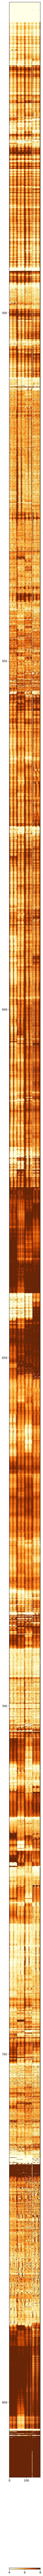

In [24]:
plt.figure(figsize=(2,200))
miny = fmsdf.index.min()
maxy = fmsdf.index.max()
plt.imshow(fmsdf, interpolation='none',
           aspect='auto', cmap=plt.cm.YlOrBr,
           vmin=4.0, vmax=8.0,
          extent=[0, 360, maxy, miny])

plt.ylim(810.75, 455.375)

plt.colorbar(orientation='horizontal', pad =0.03)